In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
tropopauses = {'mls': 40, 'saw': 45, 'trp': 37}
    
ilevels = [0, tropopauses[PARAM['atmpro']], -1]


In [11]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=ilevels)

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=ilevels)


In [12]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=ilevels)

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=ilevels)

In [13]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [14]:
def save_flux_excel():
    
    fname = 'lblnew-bestfit_flux.xlsx'
    writer = pd.ExcelWriter(fname)
    
    ds = analysis.models['crd'].data['flux']
    for g in ds.coords['g']:
        df = ds.sel(g=g).to_dataframe()
        df.to_excel(writer, f'crd flux g={int(g)}')
        
    ds = analysis.models['wgt_igg1'].data['flux']
    for g in ds.coords['g']:
        df = ds.sel(g=g).to_dataframe()
        df.to_excel(writer, f'wgt igg=1 flux g={int(g)}')
    
    ds = analysis.models['wgt_igg10'].data['flux']
    for g in ds.coords['g']:
        df = ds.sel(g=g).to_dataframe()
        df.to_excel(writer, f'wgt igg=10 flux g={int(g)}')
    
    writer.save()       
    html_download = f'Download: <a href="./{fname}">{fname}</a>'
    display.display(display.HTML(html_download))
        
    
    
def save_cool_excel():
    fname = 'lblnew-bestfit_cool.xlsx'
    writer = pd.ExcelWriter(fname)
    
    ds = analysis.models['crd'].data['cooling rate']
    for g in ds.coords['g']:
        df = ds.sel(g=g).to_dataframe()
        df.to_excel(writer, f'crd cool g={int(g)}')
        
    ds = analysis.models['wgt_igg1'].data['cooling rate']
    for g in ds.coords['g']:
        df = ds.sel(g=g).to_dataframe()
        df.to_excel(writer, f'wgt igg=1 cool g={int(g)}')
        
    ds = analysis.models['wgt_igg10'].data['cooling rate']
    for g in ds.coords['g']:
        df = ds.sel(g=g).to_dataframe()
        df.to_excel(writer, f'wgt igg=10 cool g={int(g)}')
        
    writer.save()
    html_download = f'Download: <a href="./{fname}">{fname}</a>'
    display.display(display.HTML(html_download))


In [15]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 3b
commitnumber = a22ab94
conc = 0.0008
dv = 0.001
klin = 0
molecule = co2
ng_adju = [0, 0]
ng_refs = [5, 2]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250)]
tsfc = 300
vmax = 720
vmin = 620
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66), (1.66, 1.66)]
wgt = [(0, 0.6, 0.5, 0.7, 0.8), (0.8, 0.7)]


In [16]:
save_flux_excel()
save_cool_excel()

In [17]:
fig.display_hrefanchor()

In [18]:
table_fluxg.display_hrefanchor()
#table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
#table_coolr.display_hrefanchor()

In [19]:
table_dgdgs.display_hrefanchor()

In [20]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [21]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [22]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

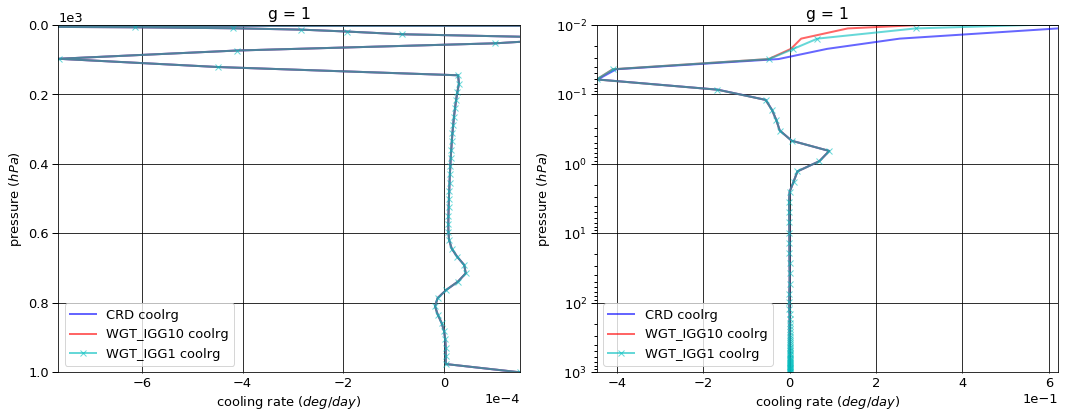

# Figure: cooling rate g-group 2

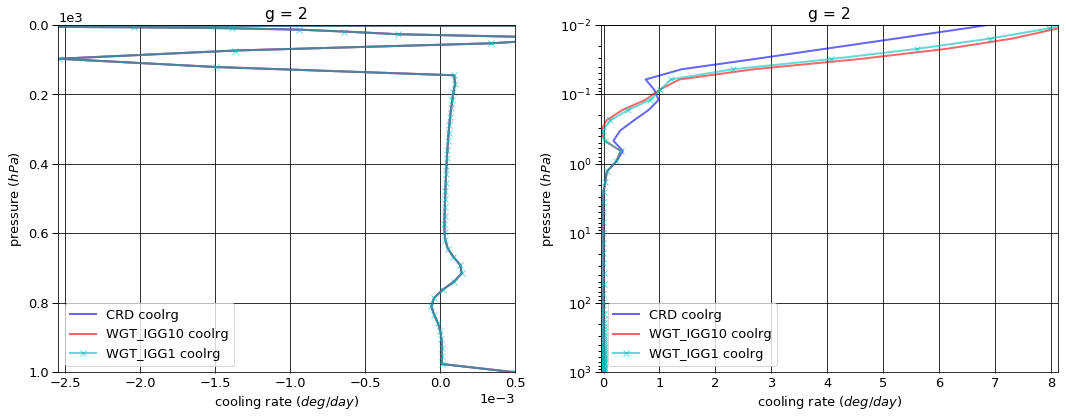

# Figure: cooling rate g-group 3

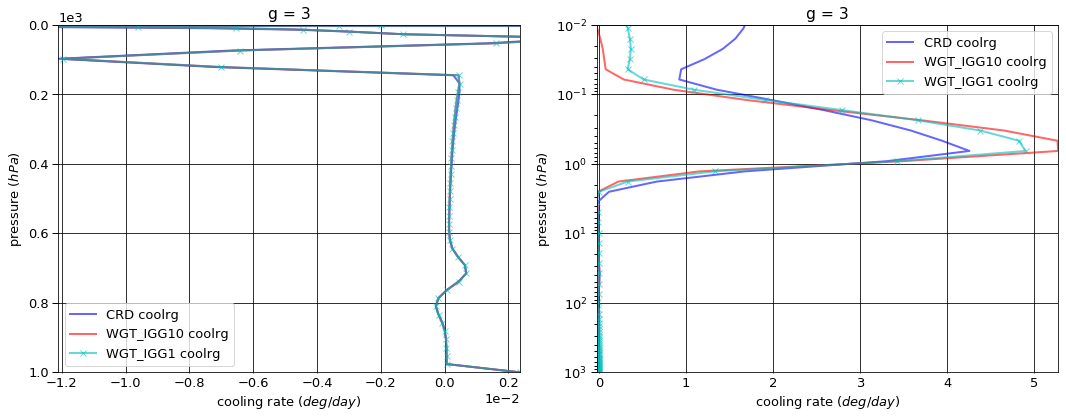

# Figure: cooling rate g-group 4

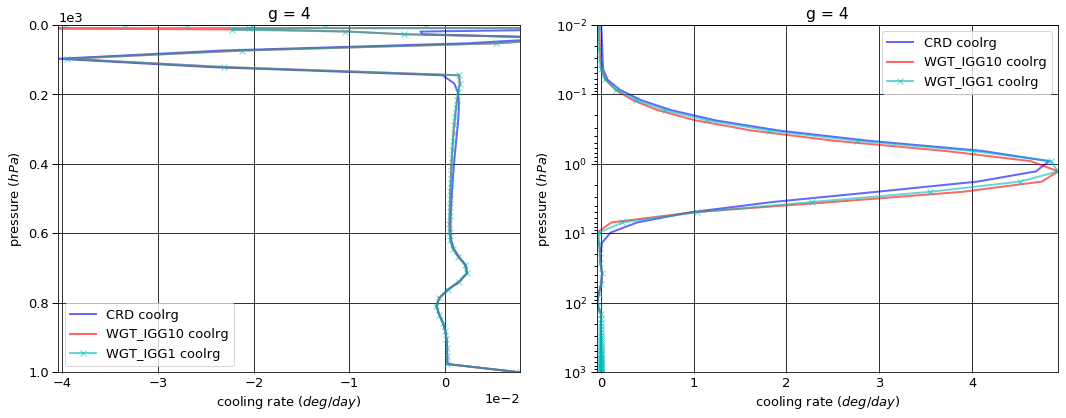

# Figure: cooling rate g-group 5

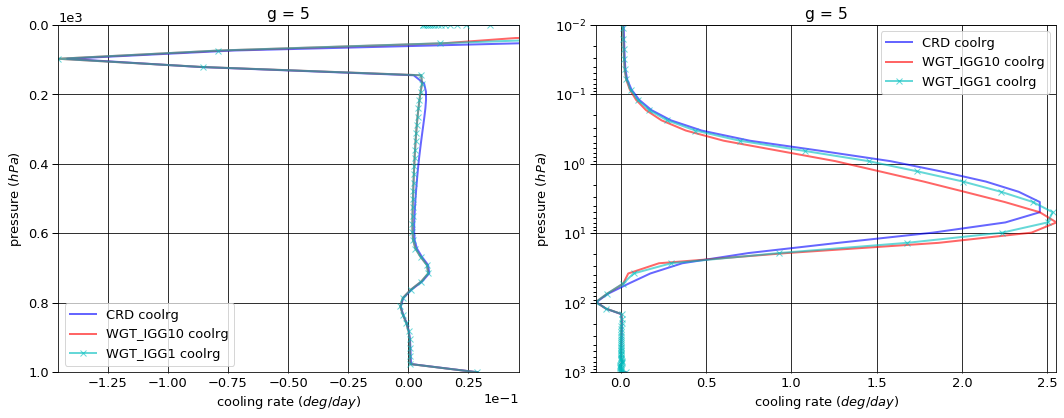

# Figure: cooling rate g-group 6

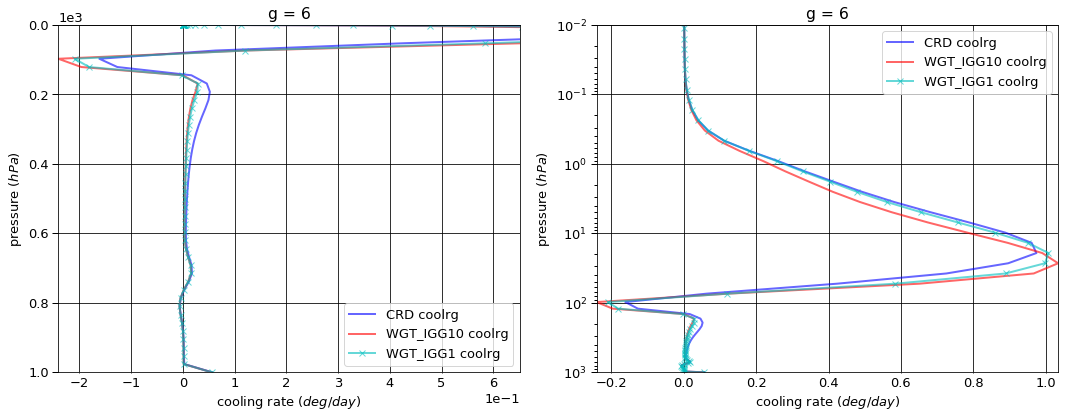

# Figure: cooling rate g-group 7

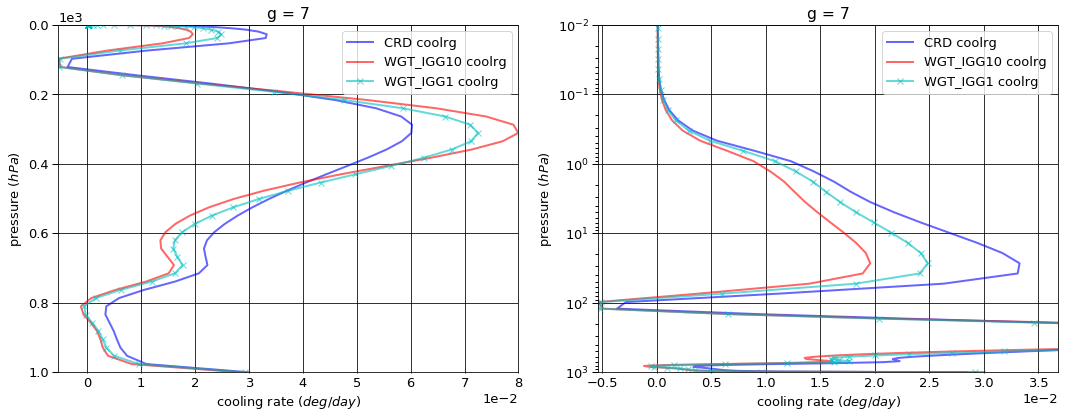

# Figure: cooling rate g-group total

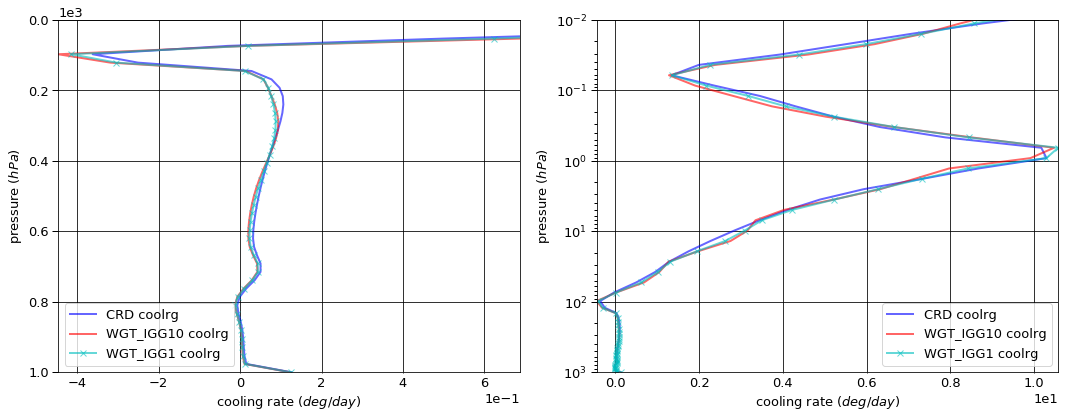

In [23]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [24]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
#table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
#table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.00     1      -0.015247   0.000000 -0.015247
  109.55   38     -0.011823   0.010926 -0.000897
  1013.00  76     -0.060398   0.059977 -0.000420
2 0.00     1      -0.066562   0.000000 -0.066562
  109.55   38     -0.039350   0.036370 -0.002980
  1013.00  76     -0.200535   0.199140 -0.001395
3 0.00     1      -0.517937   0.000000 -0.517937
  109.55   38     -0.186150   0.171869 -0.014281
  1013.00  76     -0.941872   0.935293 -0.006579
4 0.00     1      -1.702839   0.000000 -1.702839
  109.55   38     -0.627116   0.578022 -0.049094
  1013.00  76     -3.111329   3.089276 -0.022054
5 0.00     1      -4.437237   0.000000 -4.437237
  109.55   38     -2.335968   2.068101 -0.267867
  1013.00  76    -11.461662  11.379434 -0.082228
6 0.00     1      -6.208099   0.000000 -6.208099
  109.55   38     -4.957903   3.577455 -1.380448
  1013.00  76    -22.261089  22.098943 -0.162146
7 0.00     1      -3.292928   0.000000 -3.292928
  109.55   38     -3.436097   0.376514 -3.059583
  1013.00  76     -9.030664   8.892131 -0.138534


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.00     1      -0.015282   0.000000 -0.015282
  109.55   38     -0.011820   0.010923 -0.000896
  1013.00  76     -0.060448   0.060027 -0.000421
2 0.00     1      -0.058623   0.000000 -0.058623
  109.55   38     -0.039277   0.036299 -0.002978
  1013.00  76     -0.200873   0.199473 -0.001400
3 0.00     1      -0.514567   0.000000 -0.514567
  109.55   38     -0.184488   0.170498 -0.013990
  1013.00  76     -0.943517   0.936939 -0.006578
4 0.00     1      -1.778174   0.000000 -1.778174
  109.55   38     -0.609391   0.563180 -0.046211
  1013.00  76     -3.116577   3.094850 -0.021727
5 0.00     1      -4.577188   0.000000 -4.577188
  109.55   38     -2.244373   2.074180 -0.170193
  1013.00  76    -11.478279  11.398259 -0.080020
6 0.00     1      -6.007223   0.000000 -6.007223
  109.55   38     -4.512465   4.122539 -0.389926
  1013.00  76    -22.267826  22.112584 -0.155242
7 0.00     1      -3.126442   0.000000 -3.126442
  109.55   38     -3.311524   0.303347 -3.008177
  1013.00  76     -9.000028   8.899855 -0.100174


WGT_IGG1


flug       fldg     fnetg
g pressure level                                
1 0.00     1      -0.015307   0.000000 -0.015307
  109.55   38     -0.011820   0.010923 -0.000896
  1013.00  76     -0.060448   0.060027 -0.000421
2 0.00     1      -0.059314   0.000000 -0.059314
  109.55   38     -0.039277   0.036299 -0.002978
  1013.00  76     -0.200873   0.199473 -0.001400
3 0.00     1      -0.512127   0.000000 -0.512127
  109.55   38     -0.184488   0.170498 -0.013990
  1013.00  76     -0.943517   0.936939 -0.006578
4 0.00     1      -1.766342   0.000000 -1.766342
  109.55   38     -0.609391   0.563180 -0.046211
  1013.00  76     -3.116577   3.094850 -0.021727
5 0.00     1      -4.579434   0.000000 -4.579434
  109.55   38     -2.244373   2.074180 -0.170193
  1013.00  76    -11.478279  11.398259 -0.080020
6 0.00     1      -6.029992   0.000000 -6.029992
  109.55   38     -4.556188   4.066232 -0.489955
  1013.00  76    -22.267826  22.112587 -0.155239
7 0.00     1      -3.184475   0.000000 -3.184475
  109.55   38     -3.355406   0.329737 -3.025669
  1013.00  76     -9.000028   8.889279 -0.110750


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.00     1     -0.000035  0.000000 -3.478300e-05
  109.55   38     0.000003 -0.000003  6.062600e-07
  1013.00  76    -0.000051  0.000050 -1.031090e-06
2 0.00     1      0.007938  0.000000  7.938304e-03
  109.55   38     0.000073 -0.000071  1.685200e-06
  1013.00  76    -0.000339  0.000333 -5.404400e-06
3 0.00     1      0.003370  0.000000  3.369910e-03
  109.55   38     0.001662 -0.001371  2.912200e-04
  1013.00  76    -0.001644  0.001646  1.511300e-06
4 0.00     1     -0.075335  0.000000 -7.533490e-02
  109.55   38     0.017724 -0.014841  2.883167e-03
  1013.00  76    -0.005248  0.005574  3.266030e-04
5 0.00     1     -0.139951  0.000000 -1.399510e-01
  109.55   38     0.091595  0.006079  9.767399e-02
  1013.00  76    -0.016617  0.018825  2.207717e-03
6 0.00     1      0.200876  0.000000  2.008763e-01
  109.55   38     0.445438  0.545083  9.905218e-01
  1013.00  76    -0.006737  0.013641  6.903810e-03
7 0.00     1      0.166486  0.000000  1.664861e-01
  109.55   38     0.124573 -0.073167  5.140610e-02
  1013.00  76     0.030636  0.007724  3.836011e-02


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.00     1     -0.000059  0.000000 -5.926700e-05
  109.55   38     0.000003 -0.000003  6.062600e-07
  1013.00  76    -0.000051  0.000050 -1.031090e-06
2 0.00     1      0.007248  0.000000  7.247558e-03
  109.55   38     0.000073 -0.000071  1.685200e-06
  1013.00  76    -0.000339  0.000333 -5.404400e-06
3 0.00     1      0.005809  0.000000  5.809460e-03
  109.55   38     0.001662 -0.001371  2.912200e-04
  1013.00  76    -0.001644  0.001646  1.511300e-06
4 0.00     1     -0.063503  0.000000 -6.350270e-02
  109.55   38     0.017724 -0.014841  2.883167e-03
  1013.00  76    -0.005248  0.005574  3.266030e-04
5 0.00     1     -0.142197  0.000000 -1.421971e-01
  109.55   38     0.091595  0.006079  9.767387e-02
  1013.00  76    -0.016617  0.018825  2.207717e-03
6 0.00     1      0.178108  0.000000  1.781079e-01
  109.55   38     0.401716  0.488777  8.904933e-01
  1013.00  76    -0.006737  0.013644  6.906340e-03
7 0.00     1      0.108453  0.000000  1.084534e-01
  109.55   38     0.080691 -0.046777  3.391360e-02
  1013.00  76     0.030636 -0.002852  2.778424e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.00,1,-16.240850,0.000000,-16.240850
109.55,38,-11.594407,6.819257,-4.775150
1013.00,76,-47.067549,46.654193,-0.413356



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.00,1,-16.077500,0.000000,-16.077500
109.55,38,-10.913338,7.280966,-3.632372
1013.00,76,-47.067549,46.701987,-0.365563



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.00,1,-16.146990,0.000000,-16.146990
109.55,38,-11.000943,7.251050,-3.749893
1013.00,76,-47.067549,46.691414,-0.376136



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.00,1,1.633499e-01,0.000000,0.163350
109.55,38,6.810695e-01,0.461709,1.142779
1013.00,76,5.660000e-07,0.047793,0.047793



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.00,1,9.385925e-02,0.000000,0.093859
109.55,38,5.934648e-01,0.431792,1.025257
1013.00,76,5.660000e-07,0.037220,0.037220


In [25]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00128,0.001284
2,0.00425,0.004268
3,0.01996,0.020046
4,0.06595,0.066215
5,0.24303,0.243868
6,0.47273,0.473104
7,0.19280,0.191215


In [26]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.306538e-17
2,6.987267e-19
3,3.736738e-20
4,1.998379e-21
5,1.068718e-22
6,5.714218e-23
7,3.056582e-24


In [27]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [28]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.306538e-17,NaN,0.00128,0.001284,0.00128,0.001284,1.0
2,6.987267e-19,0.053479,0.00425,0.004268,0.00553,0.005552,1.0
3,3.736738e-20,0.053479,0.01996,0.020046,0.02549,0.025598,1.0
4,1.998379e-21,0.053479,0.06595,0.066215,0.09144,0.091813,1.0
5,1.068718e-22,0.053479,0.24303,0.243868,0.33447,0.335681,1.0
6,5.714218e-23,0.534680,0.47273,0.473104,0.80720,0.808785,10.0
7,3.056582e-24,0.053491,0.19280,0.191215,1.00000,1.000000,10.0


In [29]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [30]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
